In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
from scipy.optimize import fmin
import matplotlib.pyplot as plt
import seaborn as sns
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement
from aquacrop.utils import prepare_weather, get_filepath

In [2]:
# Locate weather file
filepath=get_filepath('d:/Research/sandbox/iot_extra/db/climate_data.txt')

weather_data = prepare_weather(filepath)
weather_data

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,16.85,25.42,0.39,1.04,2022-01-01
1,17.46,25.45,0.44,1.14,2022-01-02
2,18.14,24.46,0.71,0.87,2022-01-03
3,17.63,25.99,0.16,1.02,2022-01-04
4,17.27,26.51,0.07,1.12,2022-01-05
...,...,...,...,...,...
725,18.09,27.71,0.04,1.12,2023-12-27
726,19.28,27.87,0.15,1.01,2023-12-28
727,18.99,28.22,0.02,1.33,2023-12-29
728,18.82,28.29,0.01,1.19,2023-12-30


In [9]:
# Simulation period
sim_start = '2022/01/01'
sim_end = '2023/12/31'
plant_date = '11/15'
harvest_date = '04/01'

In [10]:
# Proccess soil
soil_data = pd.read_csv('d:/Research/sandbox/iot_extra/db/soil_data.csv', sep=',')

In [110]:
# Add soil profile
local_soil = Soil(soil_type='ClayLoam', dz=[0.3]*2+[0.4]+[1.0])
for index, layer in soil_data.iterrows():
    local_soil.add_layer_from_texture(
        thickness=layer["thickness"],
        Sand=layer["sand"],
        Clay=layer["clay"],
        OrgMat=layer["om"],
        # Assumption full penetrability, unable to calculate for now
        penetrability=100
    ) 
local_soil.profile

,Comp,Layer,dz,dzsum,zBot,z_top,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.3,0.3,0.3,0.0,0.15,0.115,0.23,0.39,0.5,125.0,100.0,0.47
1,1,1.0,0.3,0.6,0.6,0.3,0.45,0.115,0.23,0.39,0.5,125.0,100.0,0.47
2,2,1.0,0.4,1.0,1.0,0.6,0.80,0.115,0.23,0.39,0.5,125.0,100.0,0.47
3,3,1.0,1.0,2.0,2.0,1.0,1.50,0.115,0.23,0.39,0.5,125.0,100.0,0.47


In [128]:
# Water Content
# Layers are assumed to receive different amount of water initially 
multiTawWC = InitialWaterContent(wc_type = 'Pct',
                                method = 'Depth',
                                depth_layer= [0.3, 0.6, 1, 2],
                                value = [90, 85, 65, 50])


In [138]:
# Add crop profile 
potato = Crop(
    c_name='Potato',
    planting_date=plant_date,
    #harvest_date=harvest_date,
)

In [130]:
# Irrigation method
# Uses drip irrigation
irr_mgnt = IrrigationManagement(
    irrigation_method=1, 
    SMT=[99, 99, 99, 99],
    MaxIrrSeason=750
    )

In [136]:
# combine into aquacrop model and specify start and end simulation date
model = AquaCropModel(sim_start_time=sim_start,
                      sim_end_time=sim_end,
                      weather_df=weather_data,
                      soil=local_soil,
                      crop=potato,
                      initial_water_content=multiTawWC,
                      irrigation_management=irr_mgnt, 
                      off_season=True)
model.run_model(till_termination=True)


c:\Users\LENOVO\miniconda3\envs\aqcrop_t\Lib\site-packages\aquacrop\timestep\run_single_timestep.py:416: RuntimeWarning: invalid value encountered in scalar divide
  NewCond.FreshYield = NewCond.DryYield / (crop.YldWC / 100)
c:\Users\LENOVO\miniconda3\envs\aqcrop_t\Lib\site-packages\aquacrop\timestep\run_single_timestep.py:416: RuntimeWarning: invalid value encountered in scalar divide
  NewCond.FreshYield = NewCond.DryYield / (crop.YldWC / 100)


True

100%|██████████| 10/10 [07:09<00:00, 42.90s/it]


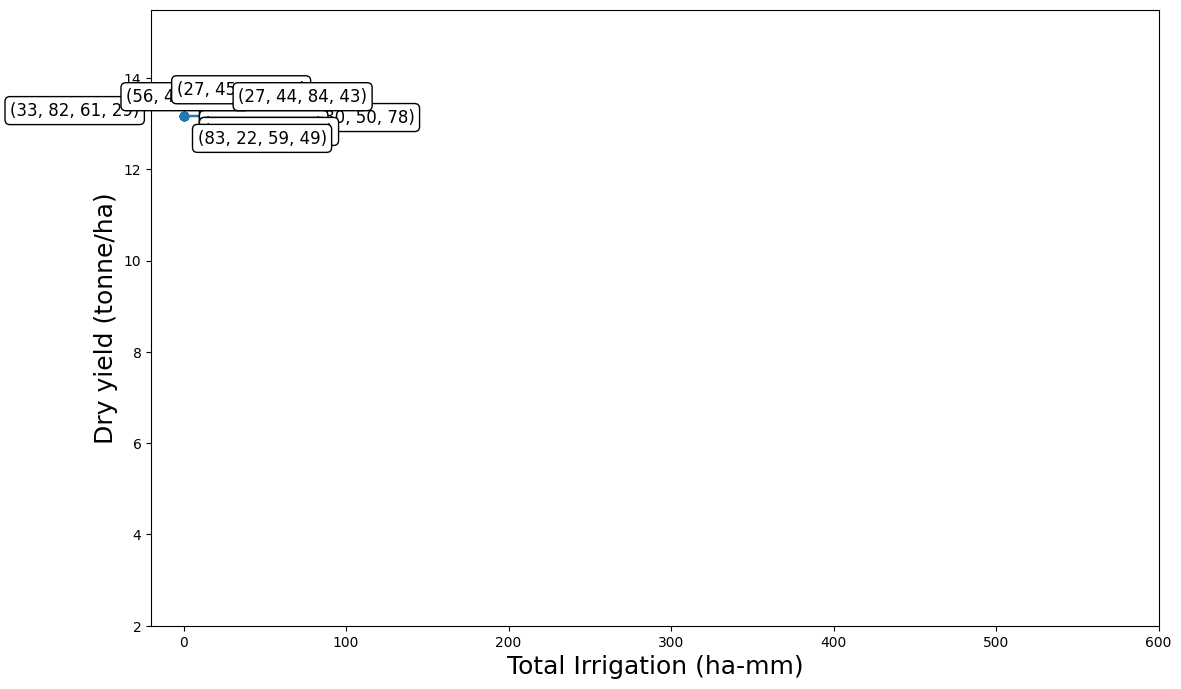

In [8]:
# Model runner 
def run_model(smt, max_irr_season, year1, year2): 
    """
    Function to run the model and return soil moisture  
    """
    weather_filepath=get_filepath(
        'd:/Research/sandbox/iot_extra/db/climate_data.txt'
        )
    soil_data = pd.read_csv(
        'd:/Research/sandbox/iot_extra/db/soil_data.csv', sep=','
        )
    
    weather_data = prepare_weather(weather_filepath)
    
    potato = Crop(c_name='Potato', planting_date=plant_date)
    
    local_soil = Soil(soil_type='ClayLoam', dz=[0.3]*2+[0.4]+[1.0])
    for index, layer in soil_data.iterrows():
        local_soil.add_layer_from_texture(
            thickness=layer["thickness"],
            Sand=layer["sand"],
            Clay=layer["clay"],
            OrgMat=layer["om"],
            # Assumption full penetrability, unable to calculate for now
            penetrability=100
        ) 
    
    multiTawWC = InitialWaterContent(
        wc_type = 'Prop',
        method = 'Depth',
        depth_layer= [1, 2, 3, 4],
        value = ["FC", "SAT", "WP", "WP"]
        )
    
    irr_mgnt = IrrigationManagement(
        irrigation_method=1, 
        SMT=smt, 
        MaxIrrSeason=max_irr_season
        )
    
    model = AquaCropModel(
        sim_start_time=f"{year1}/01/01",
        sim_end_time=f"{year2}/12/31",
        weather_df=weather_data,
        soil=local_soil,
        crop=potato,
        initial_water_content=multiTawWC,
        irrigation_management=irr_mgnt
        )
    
    model.run_model(till_termination=True)
    
    return model.get_simulation_results()
    

def evaluate(smts,max_irr_season,test=False):
    """
    function to run model and calculate reward (yield) for given set of soil moisture targets
    """
    # run model
    out = run_model(smts, max_irr_season, year1=2022, year2=2023)
    # get yields and total irrigation
    yld = out['Dry yield (tonne/ha)'].mean()
    tirr = out['Seasonal irrigation (mm)'].mean()

    reward=yld

    # return either the negative reward (for the optimization)
    # or the yield and total irrigation (for analysis)
    if test:
        return yld,tirr,reward
    else:
        return -reward

def get_starting_point(num_smts,max_irr_season,num_searches):
    """
    find good starting threshold(s) for optimization
    """

    # get random SMT's
    x0list = np.random.rand(num_searches,num_smts)*100
    rlist=[]
    # evaluate random SMT's
    for xtest in x0list:
        r = evaluate(xtest,max_irr_season,)
        rlist.append(r)

    # save best SMT
    x0=x0list[np.argmin(rlist)]
    
    return x0

def optimize(num_smts,max_irr_season,num_searches=100):
    """ 
    optimize thresholds to be profit maximising
    """
    # get starting optimization strategy
    x0=get_starting_point(num_smts,max_irr_season,num_searches)
    # run optimization
    res = fmin(evaluate, x0,disp=0,args=(max_irr_season,))
    # reshape array
    smts= res.squeeze()
    # evaluate optimal strategy
    return smts

from tqdm.autonotebook import tqdm # progress bar

opt_smts=[]
yld_list=[]
tirr_list=[]
for max_irr in tqdm(range(0,500,50)):
    

    # find optimal thresholds and save to list
    smts= optimize(4,max_irr)
    opt_smts.append(smts)

    # save the optimal yield and total irrigation
    yld,tirr,_= evaluate(smts,max_irr,True)
    yld_list.append(yld)
    tirr_list.append(tirr)
    
# create plot
fig,ax=plt.subplots(1,1,figsize=(13,8))

# plot results
ax.scatter(tirr_list,yld_list)
ax.plot(tirr_list,yld_list)

# labels
ax.set_xlabel('Total Irrigation (ha-mm)',fontsize=18)
ax.set_ylabel('Dry yield (tonne/ha)',fontsize=18)
ax.set_xlim([-20,600])
ax.set_ylim([2,15.5])

# annotate with optimal thresholds
bbox = dict(boxstyle="round",fc="1")
offset = [15,15,15, 15,15,-125,-100,  -5, 10,10]
yoffset= [0,-5,-10,-15, -15,  0,  10,15, -20,10]
for i,smt in enumerate(opt_smts):
    smt=smt.clip(0,100)
    ax.annotate('(%.0f, %.0f, %.0f, %.0f)'%(smt[0],smt[1],smt[2],smt[3]),
                (tirr_list[i], yld_list[i]), xytext=(offset[i], yoffset[i]), textcoords='offset points',
                bbox=bbox,fontsize=12)


                  

In [113]:
# Calculate yearly precipitation 
weather_data['Year'] = weather_data['Date'].dt.year
yearly_precip = weather_data.groupby('Year')['Precipitation'].sum().reset_index()


# If you need multiple aggregations
#yearly_stats = weather_data.groupby('Year')['Precipitation'].agg(['sum', 'mean', 'count']).reset_index()
yearly_precip

,Year,Precipitation
0,2022,1729.84
1,2023,1582.04


In [137]:
pd.set_option('display.max_rows', 20)  # or a large number like 1000
pd.set_option('display.max_columns', None)  # or a large number like 100
#model._outputs.water_flux.head(100)
#model._outputs.water_storage.head()
#model._outputs.crop_growth
#model._outputs.final_stats
model._outputs.final_stats.head(20)

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Dry yield (tonne/ha),Fresh yield (tonne/ha),Yield potential (tonne/ha),Seasonal irrigation (mm)
0,0,Cassava,2022-12-10,342,0.0,NaN,0.0,3.063029
1,1,Cassava,2023-12-10,707,0.0,NaN,0.0,11.640962


In [127]:

model._outputs.water_flux.IrrDay.head(10)
date_range = pd.date_range(start=sim_start, end=sim_end)
irr_df = pd.DataFrame({
    'Year': date_range.year,
    'Month': date_range.month,
    'Day': date_range.day
})
irr_day_values = model._outputs.water_flux['IrrDay']
irr_df['IrrDay'] = irr_day_values.values[:len(date_range)]
irr_df.to_csv('db/irr_schedule.csv',sep=',',index=False)
